# Text Mining

In [26]:
from pdfminer.high_level import extract_text
import matplotlib.pyplot as plt
import streamlit as st
import os

# Une fonction pour l'extraction du texte dans le pdf
def extract_text_from_pdf(pdf_path):
 
    if not os.path.exists(pdf_path):
        print(f"Erreur : Le fichier '{pdf_path}' n'existe pas. Vérifiez le chemin.")
        return None

    try:
        text = extract_text(pdf_path)
        return text
    except Exception as e:
        print(f"Erreur lors de l'extraction du texte du PDF : {e}")
        return None


pdf_file_path = "article_VO.pdf"

article_text = extract_text_from_pdf(pdf_file_path)

if article_text:
    print(f"Texte extrait :\n{'-'*30}\n{article_text[:500]}...\n{'-'*30}")
else:
    print("Échec de l'extraction du texte. Le nuage de mots ne pourra pas être généré.")

Texte extrait :
------------------------------
Communiqué de presse 
10 octobre 2024 

« Le bon observatoire des véhicules d’occasion », publié 
par leboncoin automobile, analyse les vrais prix du marché 

Alors que le marché des véhicules d’occasion affiche une hausse de 6% au mois de 
septembre,  la  tendance  est  à  une  nouvelle  baisse  des  prix  moyens.  Ce  sont  les 
enseignements tirés par leboncoin auto qui publie son nouveau baromètre mensuel « 
le bon observatoire des véhicules d’occasion ». 

Avec 14,8 millions de visiteurs pa...
------------------------------


In [ ]:
#important de télecharger le package de mots de la librairie scapy
#  python -m spacy download fr_core_news_sm

In [27]:
import spacy
from collections import Counter
import re
from wordcloud import WordCloud


# Charger le modèle spaCy pour le français
try:
    nlp = spacy.load("fr_core_news_sm")
except OSError:
    print("Modèle spaCy 'fr_core_news_sm' non trouvé. Veuillez l'installer avec : python -m spacy download fr_core_news_sm")
    exit() # Quitte le script si le modèle n'est pas là

def preprocess_text_for_wordcloud(text):

    """
    Prétraite le texte pour un nuage de mots pertinent en français.
    Mise en minuscules, suppression de la ponctuation, des nombres, des mots vides et lemmatisation.
    """
    doc = nlp(text.lower()) # Convertir en minuscules et traiter

    tokens = []
    for token in doc:
        # Filtrer :
        # - is_punct : Ponctuation
        # - is_space : Espaces, retours chariot
        # - is_stop : Mots vides (articles, prépositions, conjonctions, etc.)
        # - is_alpha : S'assurer que c'est bien une lettre (pas un nombre ou un symbole après filtrage)
        # - len(token.lemma_) > 1 : Éliminer les caractères uniques restants
        if not token.is_punct and not token.is_space and not token.is_stop and token.is_alpha and len(token.lemma_) > 1:
            tokens.append(token.lemma_) # Utiliser la lemmatisation

    return tokens

if article_text:
    processed_tokens = preprocess_text_for_wordcloud(article_text)
    print(f"\nTokens prétraités (aperçu des 50 premiers) :\n{processed_tokens[:50]}...")

    # Calculer la fréquence des mots après prétraitement
    word_counts = Counter(processed_tokens)
    print(f"\n20 mots les plus fréquents après prétraitement :\n{word_counts.most_common(20)}")
else:
    print("Le texte n'a pas pu être prétraité car il n'a pas été extrait du PDF.")


Tokens prétraités (aperçu des 50 premiers) :
['communiquer', 'presse', 'octobre', 'bon', 'observatoire', 'véhicule', 'occasion', 'publier', 'leboncoin', 'automobile', 'analyse', 'vrai', 'prix', 'marché', 'marché', 'véhicule', 'occasion', 'affich', 'hausse', 'mois', 'septembre', 'tendance', 'nouveau', 'baisse', 'prix', 'moyen', 'enseignement', 'tirer', 'leboncoin', 'auto', 'publier', 'baromètre', 'mensuel', 'bon', 'observatoire', 'véhicule', 'occasion', 'million', 'visiteur', 'mois', 'leboncoin', 'auto', 'marque', 'préféré', 'français', 'acheter', 'vendre', 'véhicule', 'expert', 'marché']...

20 mots les plus fréquents après prétraitement :
[('prix', 28), ('véhicule', 19), ('occasion', 19), ('leboncoin', 16), ('marché', 14), ('bon', 8), ('mois', 8), ('septembre', 8), ('professionnel', 8), ('moyen', 7), ('vendre', 7), ('transaction', 7), ('voiture', 7), ('an', 7), ('baisse', 6), ('particulier', 6), ('acheteur', 6), ('auto', 5), ('million', 5), ('annonce', 5)]


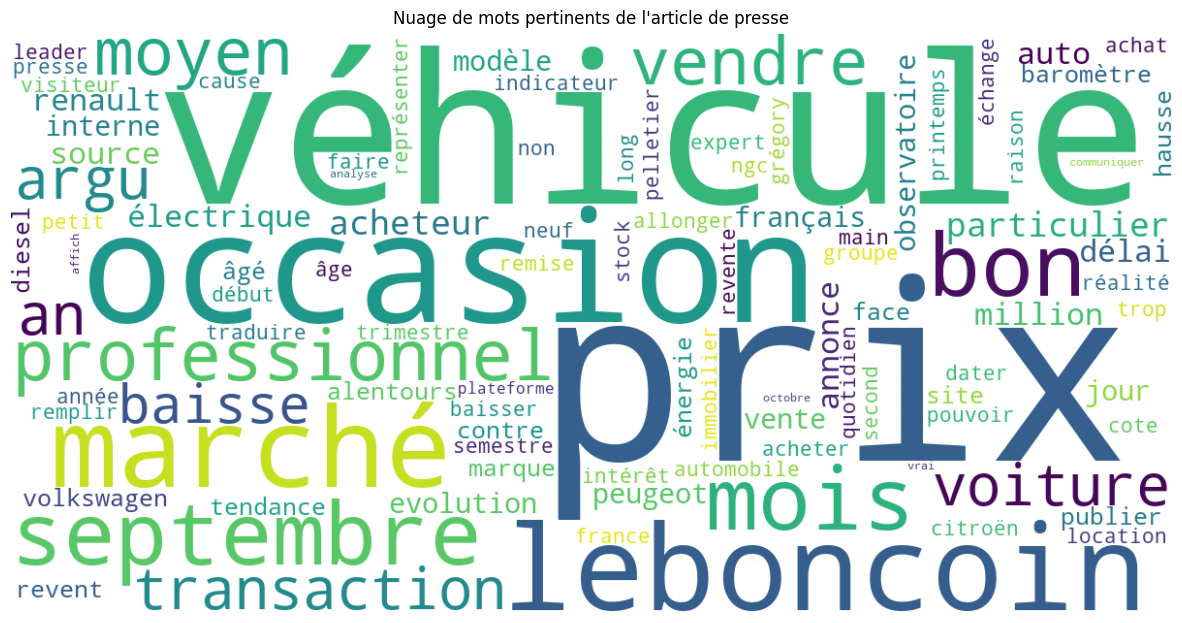

Word cloud saved to: images\wordcloud.png


In [31]:
if processed_tokens:
    text_for_wordcloud = " ".join(processed_tokens)

    # Configurer le WordCloud
    # 'width' et 'height' : Taille de l'image
    # 'background_color' : Couleur de fond
    # 'max_words' : Nombre maximal de mots à afficher
    # 'min_font_size' : Taille minimale des polices
    # 'collocations=False' : Important pour éviter que WordCloud ne regroupe des mots comme "pomme de" s'ils ne sont pas un concept unique
    # 'stopwords' : Même si déjà filtrés, on peut les repasser pour être sûr (WordCloud a aussi sa propre liste)
    #               Pour WordCloud, il faut une liste, pas un set.
    french_stopwords = spacy.lang.fr.stop_words.STOP_WORDS # Utilise la liste de mots vides de spaCy

    wordcloud = WordCloud(width=1200, height=600,
                          background_color='white',
                          max_words=100, # Afficher les 100 mots les plus pertinents
                          min_font_size=10,
                          collocations=False,
                          stopwords=french_stopwords # Appliquer les stopwords ici aussi
                         ).generate(text_for_wordcloud) # Utiliser la chaîne de tokens prétraités

    # Afficher le nuage de mots
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Cache les axes
    plt.title("Nuage de mots pertinents de l'article de presse")
    plt.show()
    
    # Sauvegarde l'image du WordCloud
    def generate_and_save_wordcloud(wordcloud, output_filename="wordcloud.png"):
        # Créer le dossier images si nécessaire
        if not os.path.exists('images'):
            os.makedirs('images')
        
        # Définir le chemin complet du fichier
        output_path = os.path.join('images', output_filename)
        
        # Sauvegarder l'image du WordCloud dans le dossier 'images'
        wordcloud.to_file(output_path)
        return output_path
    
    # Sauvegarder le fichier dans le dossier 'images'
    image_path = generate_and_save_wordcloud(wordcloud, output_filename="wordcloud.png")
    print(f"Word cloud saved to: {image_path}")
else:
    print("Impossible de générer le nuage de mots car aucun token pertinent n'a été extrait.")